# Begining

## imports

In [2]:
import os
import random
import pathlib
import time
import struct
import collections


import numpy as np
import pandas as pd
import scipy
import scipy.fft

import soundfile as sf
import librosa
import librosa.display

import IPython.display as ipd

from matplotlib import pyplot as plt
import seaborn as sns

import sqlite3
import json

import torch as torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from tqdm.notebook import tqdm

from datasets import load_dataset, load_metric

In [3]:
print(torch.backends.cuda.is_built())
print(torch.__version__)

True
2.4.1+cu118


## dataset numbers

In [4]:
dataset = load_dataset("superb", "ks")

train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

In [5]:
NUMBER_OF_TRAIN_AUDIOTRACKS = len(dataset['train']['label'])
NUMBER_OF_VALIDATION_AUDIOTRACKS = len(dataset['validation']['label'])
NUMBER_OF_TEST_AUDIOTRACKS = len(dataset['test']['label'])

FOLDER_SIZE = 2048        # each folder contains spectrogramms of up to 2048 audiotracks

NUMBER_OF_TRAIN_FOLDERS = NUMBER_OF_TRAIN_AUDIOTRACKS // FOLDER_SIZE + 1
NUMBER_OF_VALIDATION_FOLDERS = NUMBER_OF_VALIDATION_AUDIOTRACKS // FOLDER_SIZE + 1
NUMBER_OF_TEST_FOLDERS = NUMBER_OF_TEST_AUDIOTRACKS // FOLDER_SIZE + 1

FRAME_LENGTH = 2048
HOP_LENGTH = 512
TARGET_DURATION = 1
TIME_CUT_SIZE = 44 # this is number of frames equal to 1 second (1 sec = 44 frames)

LONG_DATATYPE_BYTES = 4
LONG_LONG_DATATYPE_BYTES = 8
DOUBLE_DATATYPE_BYTES = 8

In [6]:
# os.path.abspath(os.path.join(pathlib.Path().resolve(), os.pardir)) - подняться на 1 уровень
# os.pardir == '..'
SOUND_EDA_FOLDER = pathlib.Path().resolve()

TRAIN_FOLDER = os.path.join(SOUND_EDA_FOLDER, 'train_folder')
if not os.path.isdir(TRAIN_FOLDER):
   os.makedirs(TRAIN_FOLDER)

VALIDATION_FOLDER = os.path.join(SOUND_EDA_FOLDER, 'validation_folder')
if not os.path.isdir(VALIDATION_FOLDER):
   os.makedirs(VALIDATION_FOLDER)

TEST_FOLDER = os.path.join(SOUND_EDA_FOLDER, 'test_folder')
if not os.path.isdir(TEST_FOLDER):
   os.makedirs(TEST_FOLDER)

LEARNING_RESULTS_0_FOLDER = os.path.join(SOUND_EDA_FOLDER, 'learning_results_0_folder')
if not os.path.isdir(LEARNING_RESULTS_0_FOLDER):
   os.makedirs(LEARNING_RESULTS_0_FOLDER)

COMMON_FILES_FOLDER = os.path.join(SOUND_EDA_FOLDER, 'common_files_folder')
if not os.path.isdir(COMMON_FILES_FOLDER):
   os.makedirs(COMMON_FILES_FOLDER)

In [7]:
print(len(train_dataset))
print(len(validation_dataset))    
print(len(test_dataset))

64727
6798
3081


durations_counts = {}
durations_idxs = {}

sr_counts = {}
sr_idxs = {}

for i in tqdm(range(len(train_dataset))):
    wav_array, sr = librosa.load(dataset['train']["file"][i], mono = True)
    current_duration = len(wav_array)
    if not current_duration in durations_counts.keys():
        durations_counts[current_duration] = 1
        durations_idxs[current_duration] = [i]
    else:
        durations_counts[current_duration] += 1
        durations_idxs[current_duration].append(i)
    
    if not sr in sr_counts.keys():
        sr_counts[sr] = 1
        sr_idxs[sr] = [i]
    else:
        sr_counts[sr] += 1
        sr_idxs[sr].append(i)

with open(os.path.join(COMMON_FILES_FOLDER, 'durations_counts.json'), "w") as outfile: 
    json.dump(durations_counts, outfile)

with open(os.path.join(COMMON_FILES_FOLDER, 'durations_idxs.json'), "w") as outfile: 
    json.dump(durations_idxs, outfile)

with open(os.path.join(COMMON_FILES_FOLDER, 'sr_counts.json'), "w") as outfile: 
    json.dump(sr_counts, outfile)

with open(os.path.join(COMMON_FILES_FOLDER, 'sr_idxs.json'), "w") as outfile: 
    json.dump(sr_idxs, outfile)
        

In [8]:
with open(os.path.join(COMMON_FILES_FOLDER, 'durations_counts.json'), "r") as intfile: 
    durations_counts = json.load(intfile)

with open(os.path.join(COMMON_FILES_FOLDER, 'durations_idxs.json'), "r") as intfile: 
    durations_idxs = json.load(intfile)

integer_keys = [int(key) for key in durations_counts.keys()]
integer_keys.sort()
for key in integer_keys:
    print(key, durations_counts[str(key)]) 
    pass
# only 5 audios have length more than 1 second

8193 1
8468 1
9217 4
9409 6
10115 2
10241 11
10350 6
10820 1
11056 3
11265 17
11290 53
11526 1
11761 1
12231 70
12289 35
12467 4
12937 4
13173 88
13313 59
13407 1
13643 3
13826 1
13878 1
14112 111
14337 83
14348 1
14584 1
14818 2
15054 176
15289 1
15361 157
15524 4
15759 1
15876 1
15995 259
16229 4
16385 215
16465 6
16701 5
16898 3
16935 269
17171 2
17199 2
17406 10
17409 265
17640 5
17876 406
17922 1
18112 6
18346 8
18433 331
18582 2
18817 451
19052 1
19287 11
19457 402
19523 3
19757 503
19970 3
19993 4
20229 12
20463 3
20481 478
20699 632
20883 3
20934 4
20993 3
21168 21
21324 1
21404 7
21505 494
21640 715
21765 1
21874 5
22017 2
22050 58252
1323000 2
1348479 1
1350648 1
1362816 1
2098788 1


In [9]:
#number of classes
print(np.max(np.array(train_dataset['label'])))
print(np.max(np.array(validation_dataset['label'])))
print(np.max(np.array(test_dataset['label'])))

11
11
11


In [10]:
unique_labels = np.unique(np.array(train_dataset['label']))
unique_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [11]:
amounts = {}
for label in unique_labels:
    amounts[label] = np.sum(np.array(train_dataset['label']) == label)
amounts

{0: 2377,
 1: 2375,
 2: 2375,
 3: 2359,
 4: 2353,
 5: 2367,
 6: 2367,
 7: 2357,
 8: 2380,
 9: 2372,
 10: 6,
 11: 41039}

In [12]:
# lets save indeces of all audios without 11th class
filtered_indices = np.nonzero(np.array(train_dataset['label']) != 11)

with open(os.path.join(COMMON_FILES_FOLDER, 'indeces_without_11th_class.json'), 'w') as outfile:
    json.dump(filtered_indices[0].tolist(), outfile)

In [58]:
#0th track in 10th class is 1:35 - 95 spectrogramms
#1sttrack in 10th class is 1:01 - 61 spectrogramms
#2ndtrack in 10th class is 1:01 - 61 spectrogramms
#3rdtrack in 10th class is 1:00 - 60 spectrogramms
#4thtrack in 10th class is 1:01 - 61 spectrogramms
#5thtrack in 10th class is 1:00 - 60 spectrogramms
#so we need to change amounts
amounts[10] += (94+60+60+59+60+59)


weights = [sum(amounts.values())/amounts[label] for label in amounts.keys()]
weights

[13.56640625,
 13.781746031746032,
 12.768382352941176,
 13.727272727272727,
 13.00749063670412,
 13.40926640926641,
 14.117886178861788,
 13.255725190839694,
 13.947791164658634,
 13.836653386454183,
 5.351309707241911,
 13.513618677042802]

In [14]:
amounts = {}
for label in unique_labels:
    amounts[label] = np.sum(np.array(test_dataset['label']) == label)
amounts

{0: 256,
 1: 252,
 2: 272,
 3: 253,
 4: 267,
 5: 259,
 6: 246,
 7: 262,
 8: 249,
 9: 251,
 10: 257,
 11: 257}

In [61]:
np.where(np.array(test_dataset['label']) == 5)

(array([2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055,
        2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066,
        2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077,
        2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088,
        2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099,
        2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110,
        2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121,
        2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132,
        2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143,
        2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154,
        2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165,
        2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176,
        2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187,
        2188, 2189, 2190, 2191, 2192, 

In [57]:
test_tens = np.where(np.array(train_dataset['label']) == 10)
print(test_tens)
wav_array, sr = librosa.load(dataset['train']["file"][5], mono = True)

ipd.Audio(wav_array, rate=sr)

(array([0, 1, 2, 3, 4, 5], dtype=int64),)


In [16]:
np.where(np.array(train_dataset['label']) == 10)

(array([0, 1, 2, 3, 4, 5], dtype=int64),)

In [17]:
wav_array, sr = librosa.load(dataset['train']["file"][2], mono = True)

ipd.Audio(wav_array, rate=sr)

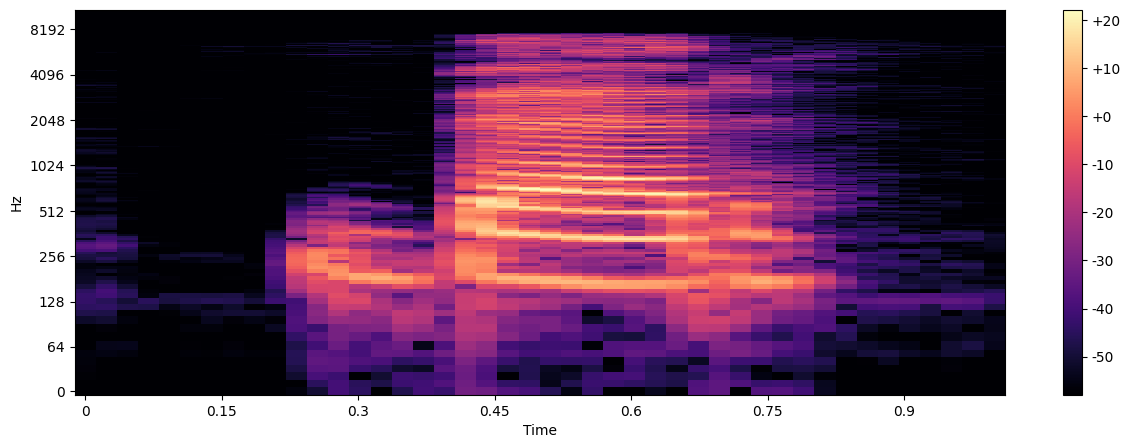

In [18]:
id_of_audio = 34


wav_array, sr = librosa.load(dataset['train']["file"][id_of_audio], mono = True)



stft_wav_array = librosa.stft(wav_array, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)
power_stft_wav_array = np.abs(stft_wav_array)**2
log_power_stft_wav_array = librosa.power_to_db(power_stft_wav_array)

res = None
time_dim_shape = log_power_stft_wav_array.shape[1]
        
"""if time_dim_shape < TIME_CUT_SIZE:
            
    res = np.zeros((log_power_stft_wav_array.shape[0], TIME_CUT_SIZE))
    res[:,:time_dim_shape] = log_power_stft_wav_array
            
else:
            
    res = log_power_stft_wav_array[:,:TIME_CUT_SIZE]"""

plt.figure(figsize=(15, 5))
librosa.display.specshow(log_power_stft_wav_array,
                            sr=22050,
                            hop_length=HOP_LENGTH,
                            x_axis='time',
                            y_axis='log')
plt.colorbar(format='%+2.f')

# data transformer class

In [19]:
class DataTransformer():
    def __init__(self, dataset, frame_length, hop_length, target_duration):
        self.frame_length = frame_length
        self.hop_length = hop_length
        self.dataset = dataset
        self.target_duration = target_duration

    def __len__(self):
        return len(self.dataset["file"])
    
    def load(self, idx):
        wav_array, sr = librosa.load(self.dataset["file"][idx], mono = True)
        return wav_array, sr

    def fix_length(self, wav_array, sr):
        target_len = int(self.target_duration * sr)
        if len(wav_array) < int(target_len*1.5):
            # Дополняем нулями, если аудио короче целевой длины
            wav_array = librosa.util.fix_length(wav_array, size=target_len)
            return [wav_array] #возвращаем список, чтобы не было ошибки в дальнейшем коде
        elif len(wav_array) > int(target_len*1.5):
            # Нарезаем на фрагменты, если аудио длиннее целевой длины
            segments = []
            for i in range(0, len(wav_array) - target_len + 1, target_len):
                segment = wav_array[i:i + target_len]
                segments.append(segment)
            return segments
        else:
            return [wav_array] #возвращаем список, чтобы не было ошибки в дальнейшем коде

    def wav_to_spectrogramm(self, wav_array):
        spectrograms = []
        if type(wav_array) == list:
            for wav in wav_array:
                stft_wav_array = librosa.stft(wav, n_fft=self.frame_length, hop_length=self.hop_length)
                power_stft_wav_array = np.abs(stft_wav_array)**2
                log_power_stft_wav_array = librosa.power_to_db(power_stft_wav_array)
                spectrograms.append(log_power_stft_wav_array)
            return spectrograms
        else:
            stft_wav_array = librosa.stft(wav_array, n_fft=self.frame_length, hop_length=self.hop_length)
            power_stft_wav_array = np.abs(stft_wav_array)**2
            log_power_stft_wav_array = librosa.power_to_db(power_stft_wav_array)
            return [log_power_stft_wav_array] #возвращаем список, чтобы не было ошибки в дальнейшем коде
    
    def get_label(self, idx):
        return self.dataset["label"][idx]
    

In [20]:
train_data_transformer = DataTransformer(dataset['train'], FRAME_LENGTH, HOP_LENGTH, TARGET_DURATION)
validation_data_transformer = DataTransformer(dataset['validation'], FRAME_LENGTH, HOP_LENGTH, TARGET_DURATION)
test_data_transformer = DataTransformer(dataset['test'], FRAME_LENGTH, HOP_LENGTH, TARGET_DURATION)

In [59]:
test_audio, test_sr = train_data_transformer.load(2)
print(f'type(test_audio): {type(test_audio)}, shape(test_audio): {test_audio.shape}')
test_audio = train_data_transformer.fix_length(test_audio, test_sr)
print(type(test_audio))
res = train_data_transformer.wav_to_spectrogramm( test_audio )
test_spectrogramm_shape = res[0].shape

print(test_spectrogramm_shape)
print(len(res[0]))

type(test_audio): <class 'numpy.ndarray'>, shape(test_audio): (1350648,)
<class 'list'>
(1025, 44)
1025


# train dataset conversion

In [21]:
def save_spectrogramm(spectrogram, label, current_folder, id_of_current_track):
    current_file_path = os.path.join(current_folder, f'spectrogramm_{id_of_current_track}')
    with open(current_file_path, mode="wb") as outfile_current:
        # Записываем метку
        outfile_current.write(struct.pack('L', label))

        # Записываем форму спектрограммы
        shape = spectrogram.shape
        outfile_current.write(struct.pack('LL', shape[0], shape[1])) # Записываем два unsigned long (высота и ширина)

        # Записываем спектрограмму целиком
        spectrogram.tofile(outfile_current)

def load_spectrogramm(current_file_path):
    with open(current_file_path, mode="rb") as infile_current:
        # Читаем метку
        chunk = infile_current.read(4) # 4 байта для unsigned long
        label = struct.unpack("L", chunk)[0]

        # Читаем форму спектрограммы
        shape_bytes = infile_current.read(8) # 8 байт для двух unsigned long
        shape = struct.unpack('LL', shape_bytes)

        # Читаем спектрограмму целиком
        spectrogram = np.fromfile(infile_current, dtype=np.float32).reshape(shape)  
    return spectrogram, label

In [22]:
# train_dataset audiofiles conversion to spectrogramms

general_file_path = os.path.join(TRAIN_FOLDER, 'general_file')

id_of_current_track = 0             # индекс аудио, такой же как индекс в оригинальном датасете
global_spectrogramm_id = 0          # так как мы нарезаем длинные аудио на куски длинной 1 сек, количество созданных спектрограмм имеет свой отдельный индекс
folder_index = 0                    # Индекс текущей папки
spectrogramm_in_folder_counter = 0  #счетчик спектрограмм в папке

with open(general_file_path, mode="wb") as outfile_general_file:
    for _ in tqdm(range(NUMBER_OF_TRAIN_AUDIOTRACKS)):
        current_audio, current_sr = train_data_transformer.load(id_of_current_track)
        current_audio = train_data_transformer.fix_length(current_audio, current_sr)
        spectrogramms = train_data_transformer.wav_to_spectrogramm(current_audio)

        current_label = train_data_transformer.get_label(id_of_current_track)

        for spectrogramm in spectrogramms:
            # Создаем новую папку, если текущая заполнена
            if global_spectrogramm_id % 2048 == 0:  # Проверяем глобальный счетчик
                current_folder = os.path.join(TRAIN_FOLDER, f'{folder_index*2048}-{(folder_index+1)*2048-1}')
                if not os.path.isdir(current_folder):
                    os.makedirs(current_folder)
                folder_index += 1

            spectrogramm_frequencyframes = spectrogramm.shape[0]
            spectrogramm_timeframes = spectrogramm.shape[1]

            save_spectrogramm(spectrogramm, current_label, current_folder, global_spectrogramm_id)

            outfile_general_file.write(struct.pack("L", id_of_current_track))       #id of track (исходного файла)
            outfile_general_file.write(struct.pack("L", global_spectrogramm_id))    #id spectrogramm
            outfile_general_file.write(struct.pack("L", current_label))             #label of track
            outfile_general_file.write(struct.pack("L", spectrogramm_frequencyframes))
            outfile_general_file.write(struct.pack("L", spectrogramm_timeframes))

            global_spectrogramm_id += 1

        id_of_current_track += 1


  0%|          | 0/64727 [00:00<?, ?it/s]

## train dataset check readability

In [23]:
general_file_path = os.path.join(TRAIN_FOLDER, 'general_file')

with open(general_file_path, 'rb') as infile_files_positions_and_lenghts:
    
    id_of_audio = 22233


    seek_position_of_id_of_file = id_of_audio * ( 5 * LONG_DATATYPE_BYTES )
    #seek_position_of_id_of_current_track = seek_position_of_id_of_file + LONG_DATATYPE_BYTES
    #seek_position_of_id_of_label_of_current_track = seek_position_of_id_of_current_track + 2*LONG_DATATYPE_BYTES
    #seek_position_of_id_of_spectrogramm_frequencyframes = seek_position_of_id_of_file + 3*LONG_DATATYPE_BYTES
    #seek_position_of_id_of_spectrogramm_timeframes = seek_position_of_id_of_file + 4*LONG_DATATYPE_BYTES


    infile_files_positions_and_lenghts.seek(seek_position_of_id_of_file)
    chunk = infile_files_positions_and_lenghts.read(LONG_DATATYPE_BYTES)
    id_of_file = struct.unpack("L", chunk)[0]
    print(f'file id: ', id_of_file)

    #infile_files_positions_and_lenghts.seek(seek_position_of_id_of_current_track)
    chunk = infile_files_positions_and_lenghts.read(LONG_DATATYPE_BYTES)
    id_of_current_track = struct.unpack("L", chunk)[0]
    print(f'id_of_current_track: ', id_of_current_track)

    #infile_files_positions_and_lenghts.seek(seek_position_of_id_of_current_track)
    chunk = infile_files_positions_and_lenghts.read(LONG_DATATYPE_BYTES)
    label_of_current_track = struct.unpack("L", chunk)[0]
    print(f'label_of_current_track: ', label_of_current_track)

    #infile_files_positions_and_lenghts.seek(seek_position_of_id_of_spectrogramm_frequencyframes)
    chunk = infile_files_positions_and_lenghts.read(LONG_DATATYPE_BYTES)
    spectrogramm_frequencyframes = struct.unpack("L", chunk)[0]
    print(f'spectrogramm_frequencyframes: ', spectrogramm_frequencyframes)

    #infile_files_positions_and_lenghts.seek(seek_position_of_id_of_spectrogramm_timeframes)
    chunk = infile_files_positions_and_lenghts.read(LONG_DATATYPE_BYTES)
    spectrogramm_timeframes = struct.unpack("L", chunk)[0]
    print(f'spectrogramm_timeframes: ', spectrogramm_timeframes)



    print(f'\n')



    chunk = infile_files_positions_and_lenghts.read(LONG_DATATYPE_BYTES)
    id_of_file = struct.unpack("L", chunk)[0]
    print(f'file id: ', id_of_file)

    chunk = infile_files_positions_and_lenghts.read(LONG_DATATYPE_BYTES)
    id_of_current_track = struct.unpack("L", chunk)[0]
    print(f'id_of_current_track: ', id_of_current_track)

    chunk = infile_files_positions_and_lenghts.read(LONG_DATATYPE_BYTES)
    label_of_current_track = struct.unpack("L", chunk)[0]
    print(f'label_of_current_track: ', label_of_current_track)

    chunk = infile_files_positions_and_lenghts.read(LONG_DATATYPE_BYTES)
    spectrogramm_frequencyframes = struct.unpack("L", chunk)[0]
    print(f'spectrogramm_frequencyframes: ', spectrogramm_frequencyframes)

    chunk = infile_files_positions_and_lenghts.read(LONG_DATATYPE_BYTES)
    spectrogramm_timeframes = struct.unpack("L", chunk)[0]
    print(f'spectrogramm_timeframes: ', spectrogramm_timeframes)


infile_files_positions_and_lenghts.close()
    


file id:  21841
id_of_current_track:  22233
label_of_current_track:  11
spectrogramm_frequencyframes:  1025
spectrogramm_timeframes:  44


file id:  21842
id_of_current_track:  22234
label_of_current_track:  11
spectrogramm_frequencyframes:  1025
spectrogramm_timeframes:  44


In [69]:
id_of_current_track = 64000
folder_index = id_of_current_track//FOLDER_SIZE

current_folder = os.path.join(TRAIN_FOLDER, f'{folder_index*FOLDER_SIZE}-{(folder_index+1)*FOLDER_SIZE-1}')
current_file_path = os.path.join(current_folder, f'spectrogramm_{id_of_current_track}')

spectrogramm, label = load_spectrogramm(current_file_path)

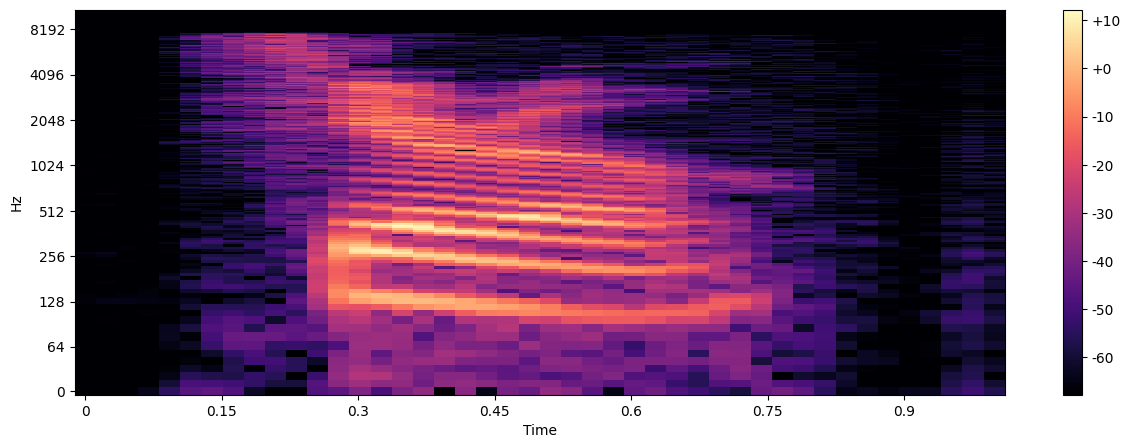

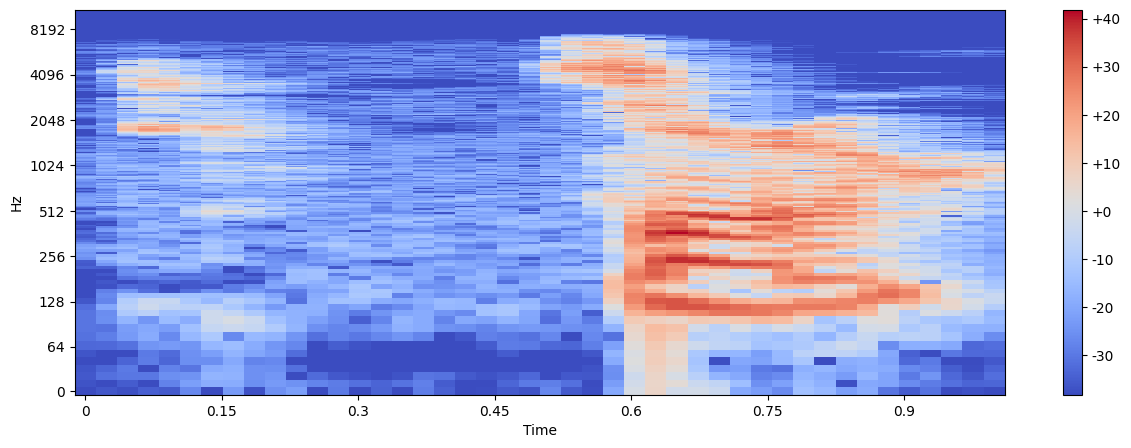

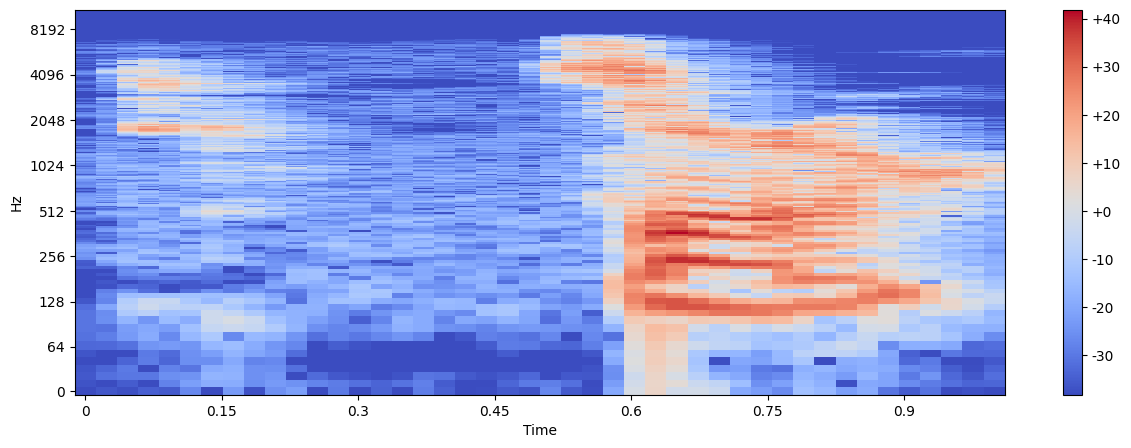

In [70]:
# plot of saved spectrogramm

plt.figure(figsize=(15, 5))
librosa.display.specshow(spectrogramm,
                            sr=22050,
                            hop_length=HOP_LENGTH,
                            x_axis='time',
                            y_axis='log')
plt.colorbar(format='%+2.f')

# plot via methods of datatransformer

test_audio, test_sr = train_data_transformer.load(id_of_current_track)
test_audio = train_data_transformer.fix_length(test_audio, test_sr)
res = train_data_transformer.wav_to_spectrogramm( test_audio )


plt.figure(figsize=(15, 5))
librosa.display.specshow(res[0],
                            sr=22050,
                            hop_length=HOP_LENGTH,
                            x_axis='time',
                            y_axis='log')
plt.colorbar(format='%+2.f')

# plot via librosa

wav_array, sr = librosa.load(dataset['train']["file"][id_of_current_track], mono = True)
target_len = int(1 * sr)
wav_array = librosa.util.fix_length(wav_array, size=target_len)
stft_wav_array = librosa.stft(wav_array, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)
power_stft_wav_array = np.abs(stft_wav_array)**2
log_power_stft_wav_array = librosa.power_to_db(power_stft_wav_array)



plt.figure(figsize=(15, 5))
librosa.display.specshow(log_power_stft_wav_array,
                            sr=sr,
                            hop_length=HOP_LENGTH,
                            x_axis='time',
                            y_axis='log')
plt.colorbar(format='%+2.f')


# if all plots are same programm saves data properly

# validation dataset conversion

In [65]:
# validation_dataset audiofiles conversion to spectrogramms

general_file_path = os.path.join(VALIDATION_FOLDER, 'general_file')

id_of_current_track = 0             # индекс аудио, такой же как индекс в оригинальном датасете
global_spectrogramm_id = 0          # так как мы нарезаем длинные аудио на куски длинной 1 сек, количество созданных спектрограмм имеет свой отдельный индекс
folder_index = 0                    # Индекс текущей папки
spectrogramm_in_folder_counter = 0  #счетчик спектрограмм в папке

with open(general_file_path, mode="wb") as outfile_general_file:
    for _ in tqdm(range(NUMBER_OF_VALIDATION_AUDIOTRACKS)):
        current_audio, current_sr = validation_data_transformer.load(id_of_current_track)
        current_audio = validation_data_transformer.fix_length(current_audio, current_sr)
        spectrogramms = validation_data_transformer.wav_to_spectrogramm(current_audio)

        current_label = validation_data_transformer.get_label(id_of_current_track)

        for spectrogramm in spectrogramms:
            # Создаем новую папку, если текущая заполнена
            if global_spectrogramm_id % 2048 == 0:  # Проверяем глобальный счетчик
                current_folder = os.path.join(VALIDATION_FOLDER, f'{folder_index*2048}-{(folder_index+1)*2048-1}')
                if not os.path.isdir(current_folder):
                    os.makedirs(current_folder)
                folder_index += 1

            spectrogramm_frequencyframes = spectrogramm.shape[0]
            spectrogramm_timeframes = spectrogramm.shape[1]

            save_spectrogramm(spectrogramm, current_label, current_folder, global_spectrogramm_id)

            outfile_general_file.write(struct.pack("L", id_of_current_track))       #id of track (исходного файла)
            outfile_general_file.write(struct.pack("L", global_spectrogramm_id))    #id spectrogramm
            outfile_general_file.write(struct.pack("L", current_label))             #label of track
            outfile_general_file.write(struct.pack("L", spectrogramm_frequencyframes))
            outfile_general_file.write(struct.pack("L", spectrogramm_timeframes))

            global_spectrogramm_id += 1

        id_of_current_track += 1

  0%|          | 0/6798 [00:00<?, ?it/s]

## validation dataset check readability

In [31]:
general_file_path = os.path.join(VALIDATION_FOLDER, 'general_file')

with open(general_file_path, 'rb') as infile_files_positions_and_lenghts:
    
    id_of_audio = 5500

    seek_position_of_id_of_file = id_of_audio * ( 5 * LONG_DATATYPE_BYTES  )


    infile_files_positions_and_lenghts.seek(seek_position_of_id_of_file)
    chunk = infile_files_positions_and_lenghts.read(LONG_DATATYPE_BYTES)
    id_of_file = struct.unpack("L", chunk)[0]

    #infile_files_positions_and_lenghts.seek(seek_position_of_id_of_current_track)
    chunk = infile_files_positions_and_lenghts.read(LONG_DATATYPE_BYTES)
    id_of_current_track = struct.unpack("L", chunk)[0]

    #infile_files_positions_and_lenghts.seek(seek_position_of_id_of_current_track)
    chunk = infile_files_positions_and_lenghts.read(LONG_DATATYPE_BYTES)
    label_of_current_track = struct.unpack("L", chunk)[0]

    #infile_files_positions_and_lenghts.seek(seek_position_of_id_of_spectrogramm_frequencyframes)
    chunk = infile_files_positions_and_lenghts.read(LONG_DATATYPE_BYTES)
    spectrogramm_frequencyframes = struct.unpack("L", chunk)[0]

    #infile_files_positions_and_lenghts.seek(seek_position_of_id_of_spectrogramm_timeframes)
    chunk = infile_files_positions_and_lenghts.read(LONG_DATATYPE_BYTES)
    spectrogramm_timeframes = struct.unpack("L", chunk)[0]
    
    print(f'file id: ', id_of_file)
    print(f'id_of_current_track: ', id_of_current_track)
    print(f'label_of_current_track: ', label_of_current_track)
    print(f'spectrogramm_frequencyframes: ', spectrogramm_frequencyframes)
    print(f'spectrogramm_timeframes: ', spectrogramm_timeframes)



    print(f'\n')



    chunk = infile_files_positions_and_lenghts.read(LONG_DATATYPE_BYTES)
    id_of_file = struct.unpack("L", chunk)[0]
    
    chunk = infile_files_positions_and_lenghts.read(LONG_DATATYPE_BYTES)
    id_of_current_track = struct.unpack("L", chunk)[0]
    
    chunk = infile_files_positions_and_lenghts.read(LONG_DATATYPE_BYTES)
    label_of_current_track = struct.unpack("L", chunk)[0]
    
    chunk = infile_files_positions_and_lenghts.read(LONG_DATATYPE_BYTES)
    spectrogramm_frequencyframes = struct.unpack("L", chunk)[0]
    
    chunk = infile_files_positions_and_lenghts.read(LONG_DATATYPE_BYTES)
    spectrogramm_timeframes = struct.unpack("L", chunk)[0]

    print(f'file id: ', id_of_file)
    print(f'id_of_current_track: ', id_of_current_track)
    print(f'label_of_current_track: ', label_of_current_track)
    print(f'spectrogramm_frequencyframes: ', spectrogramm_frequencyframes)
    print(f'spectrogramm_timeframes: ', spectrogramm_timeframes)

infile_files_positions_and_lenghts.close()

file id:  5108
id_of_current_track:  5500
label_of_current_track:  11
spectrogramm_frequencyframes:  1025
spectrogramm_timeframes:  44


file id:  5109
id_of_current_track:  5501
label_of_current_track:  11
spectrogramm_frequencyframes:  1025
spectrogramm_timeframes:  44


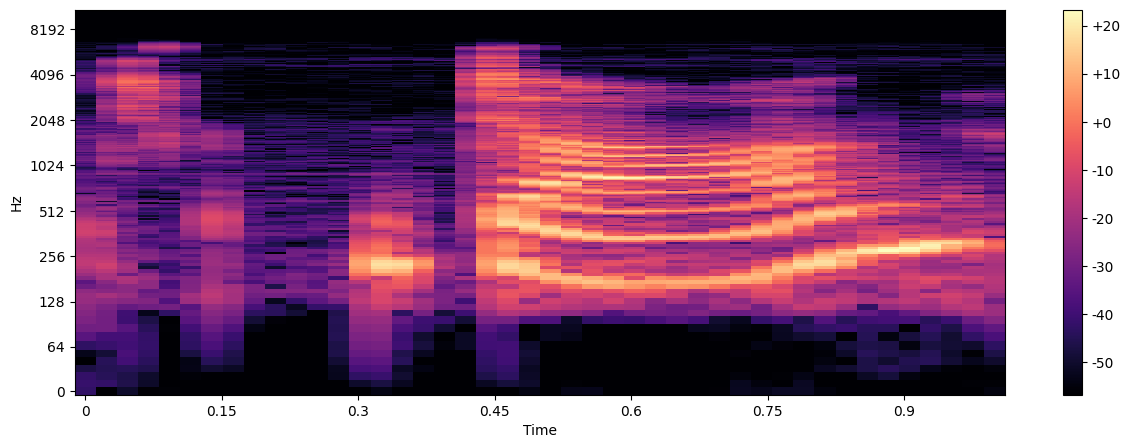

In [46]:
id_of_current_track = 6400
folder_index = id_of_current_track//FOLDER_SIZE

current_folder = os.path.join(VALIDATION_FOLDER, f'{folder_index*FOLDER_SIZE}-{(folder_index+1)*FOLDER_SIZE-1}')
current_file_path = os.path.join(current_folder, f'spectrogramm_{id_of_current_track}')

spectrogramm, label = load_spectrogramm(current_file_path)

# plot of saved spectrogramm

plt.figure(figsize=(15, 5))
librosa.display.specshow(spectrogramm,
                            sr=22050,
                            hop_length=HOP_LENGTH,
                            x_axis='time',
                            y_axis='log')
plt.colorbar(format='%+2.f')

# test dataset conversion

In [66]:
# validation_dataset audiofiles conversion to spectrogramms

general_file_path = os.path.join(TEST_FOLDER, 'general_file')

id_of_current_track = 0             # индекс аудио, такой же как индекс в оригинальном датасете
global_spectrogramm_id = 0          # так как мы нарезаем длинные аудио на куски длинной 1 сек, количество созданных спектрограмм имеет свой отдельный индекс
folder_index = 0                    # Индекс текущей папки
spectrogramm_in_folder_counter = 0  #счетчик спектрограмм в папке

with open(general_file_path, mode="wb") as outfile_general_file:
    for _ in tqdm(range(NUMBER_OF_TEST_AUDIOTRACKS)):
        current_audio, current_sr = test_data_transformer.load(id_of_current_track)
        current_audio = test_data_transformer.fix_length(current_audio, current_sr)
        spectrogramms = test_data_transformer.wav_to_spectrogramm(current_audio)

        current_label = test_data_transformer.get_label(id_of_current_track)

        for spectrogramm in spectrogramms:
            # Создаем новую папку, если текущая заполнена
            if global_spectrogramm_id % 2048 == 0:  # Проверяем глобальный счетчик
                current_folder = os.path.join(TEST_FOLDER, f'{folder_index*2048}-{(folder_index+1)*2048-1}')
                if not os.path.isdir(current_folder):
                    os.makedirs(current_folder)
                folder_index += 1

            spectrogramm_frequencyframes = spectrogramm.shape[0]
            spectrogramm_timeframes = spectrogramm.shape[1]

            save_spectrogramm(spectrogramm, current_label, current_folder, global_spectrogramm_id)

            outfile_general_file.write(struct.pack("L", id_of_current_track))       #id of track (исходного файла)
            outfile_general_file.write(struct.pack("L", global_spectrogramm_id))    #id spectrogramm
            outfile_general_file.write(struct.pack("L", current_label))             #label of track
            outfile_general_file.write(struct.pack("L", spectrogramm_frequencyframes))
            outfile_general_file.write(struct.pack("L", spectrogramm_timeframes))

            global_spectrogramm_id += 1

        id_of_current_track += 1

  0%|          | 0/3081 [00:00<?, ?it/s]

## test dataset check readability

In [34]:
general_file_path = os.path.join(TEST_FOLDER, 'general_file')

with open(general_file_path, 'rb') as infile_files_positions_and_lenghts:
    
    id_of_audio = 500


    seek_position_of_id_of_file = id_of_audio * ( 5 * LONG_DATATYPE_BYTES )


    infile_files_positions_and_lenghts.seek(seek_position_of_id_of_file)
    chunk = infile_files_positions_and_lenghts.read(LONG_DATATYPE_BYTES)
    id_of_file = struct.unpack("L", chunk)[0]
    print(f'file id: ', id_of_file)

    #infile_files_positions_and_lenghts.seek(seek_position_of_id_of_current_track)
    chunk = infile_files_positions_and_lenghts.read(LONG_DATATYPE_BYTES)
    id_of_current_track = struct.unpack("L", chunk)[0]
    print(f'id_of_current_track: ', id_of_current_track)

    #infile_files_positions_and_lenghts.seek(seek_position_of_id_of_current_track)
    chunk = infile_files_positions_and_lenghts.read(LONG_DATATYPE_BYTES)
    label_of_current_track = struct.unpack("L", chunk)[0]
    print(f'label_of_current_track: ', label_of_current_track)

    #infile_files_positions_and_lenghts.seek(seek_position_of_id_of_spectrogramm_frequencyframes)
    chunk = infile_files_positions_and_lenghts.read(LONG_DATATYPE_BYTES)
    spectrogramm_frequencyframes = struct.unpack("L", chunk)[0]
    print(f'spectrogramm_frequencyframes: ', spectrogramm_frequencyframes)

    #infile_files_positions_and_lenghts.seek(seek_position_of_id_of_spectrogramm_timeframes)
    chunk = infile_files_positions_and_lenghts.read(LONG_DATATYPE_BYTES)
    spectrogramm_timeframes = struct.unpack("L", chunk)[0]
    print(f'spectrogramm_timeframes: ', spectrogramm_timeframes)



    print(f'\n')




infile_files_positions_and_lenghts.close()

file id:  108
id_of_current_track:  500
label_of_current_track:  11
spectrogramm_frequencyframes:  1025
spectrogramm_timeframes:  44




label: 5


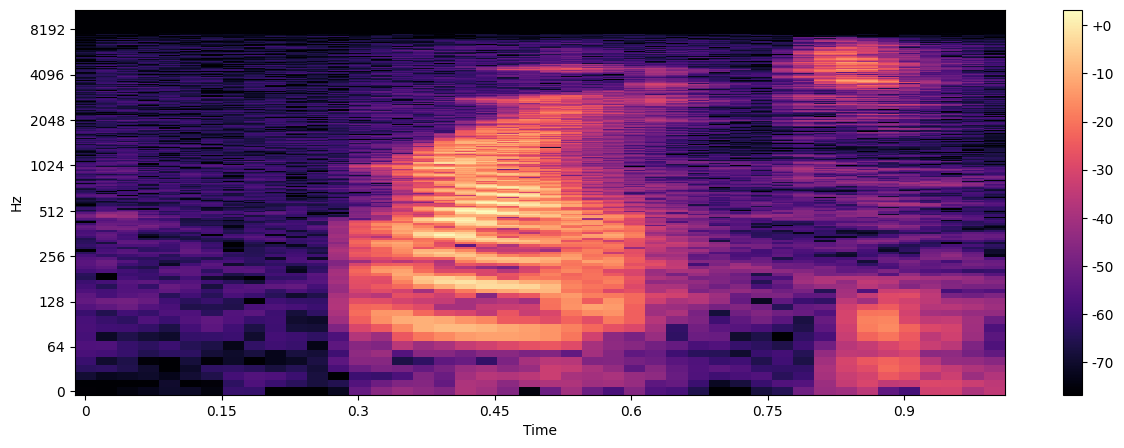

In [67]:
id_of_current_track = 2045
folder_index = id_of_current_track//FOLDER_SIZE

current_folder = os.path.join(TEST_FOLDER, f'{folder_index*FOLDER_SIZE}-{(folder_index+1)*FOLDER_SIZE-1}')
current_file_path = os.path.join(current_folder, f'spectrogramm_{id_of_current_track}')

spectrogramm, label = load_spectrogramm(current_file_path)

print(f'label: {label}')

# plot of saved spectrogramm

plt.figure(figsize=(15, 5))
librosa.display.specshow(spectrogramm,
                            sr=22050,
                            hop_length=HOP_LENGTH,
                            x_axis='time',
                            y_axis='log')
plt.colorbar(format='%+2.f')

In [40]:
general_file_path = os.path.join(TRAIN_FOLDER, 'general_file')
print(f'general_file size: ', os.path.getsize(general_file_path))
print(f'objects count: ', int(os.path.getsize(general_file_path)/(5*LONG_DATATYPE_BYTES)))

general_file size:  1302380
objects count:  65119


In [41]:
general_file_path = os.path.join(VALIDATION_FOLDER, 'general_file')
print(f'general_file size: ', os.path.getsize(general_file_path))
print(f'objects count: ', int(os.path.getsize(general_file_path)/(5*LONG_DATATYPE_BYTES)))

general_file size:  143800
objects count:  7190


In [42]:
general_file_path = os.path.join(TEST_FOLDER, 'general_file')
print(f'general_file size: ', os.path.getsize(general_file_path))
print(f'objects count: ', int(os.path.getsize(general_file_path)/(5*LONG_DATATYPE_BYTES)))

general_file size:  69460
objects count:  3473
